# **Error-Correction Modeling**

## **Getting and Visualizing the Data**

I got monthly data for the last 15 years of JP Morgan and the S&P500. I chose JP Morgan, because it showed signs of being cointegrated with the S&P500 over the training sample period. A lot of stocks did not.

In [1]:
# imports datetime for picking beginning and end dates for the analysis
import datetime
# imports yahoo finance for getting historical stock prices
import yfinance as yf
# imports pandas for dataframe manipulation
import pandas as pd
# imports numpy
import numpy as np
# for data visualization
import matplotlib as mpl
# for changing the plot size in the Jupyter Notebook output
%matplotlib inline
# for shorter lines with plotting
from matplotlib import pyplot as plt
# to hide warning messages
import warnings
warnings.filterwarnings('ignore')

# sets a variable for the number of years to look back
years = 15

# sets the sample period as x years back from 09/12/2019
end = datetime.datetime(2019, 10, 7)
start = end - datetime.timedelta(days = years*365)


# gets the closing price for a stock for the past x years
my_stock = yf.Ticker('JPM')
my_stock = pd.DataFrame(my_stock.history(start = start, end = end, interval = '1mo')['Close'])
my_stock = my_stock.rename(str.lower, axis = 'columns')

# gets the closing level for the S&P500 for the past x years
my_market = yf.Ticker('^GSPC')
my_market = pd.DataFrame(my_market.history(start = start, end = end,  interval = '1mo')['Close'])
my_market = my_market.rename(str.lower, axis = 'columns')

# grabs the last 300 observations, which will be used for a testing data set
my_stock_test = my_stock[-50:]
# creates a training subset missing the final 100 observations, which are being withheld
my_stock_train = my_stock[~my_stock.isin(my_stock_test).all(1)]

# does the same for the market
my_market_test = my_market[-50:]
# creates a training subset missing the final 100 observations, which are being withheld
my_market_train = my_market[~my_market.isin(my_stock_test).all(1)]

# performs an inner join on the data sets
my_data = my_stock.join(my_market, how = 'inner', rsuffix = '_market')

# adds 3 month lags for the market
for i in range(1, 4):
    new_col = 'close_market_l' + str(i)
    my_data[new_col] = my_data.close_market.shift(i)
    
# adds 3 month lags for the stock price
for i in range(1, 4):
    new_col = 'close_l' + str(i)
    my_data[new_col] = my_data.close.shift(i)

# creates testing and training data sets after dropping missing values
my_data = my_data.dropna()
my_data_test = my_data[-50:]
my_data_train = my_data[~my_data.isin(my_data_test).all(1)]

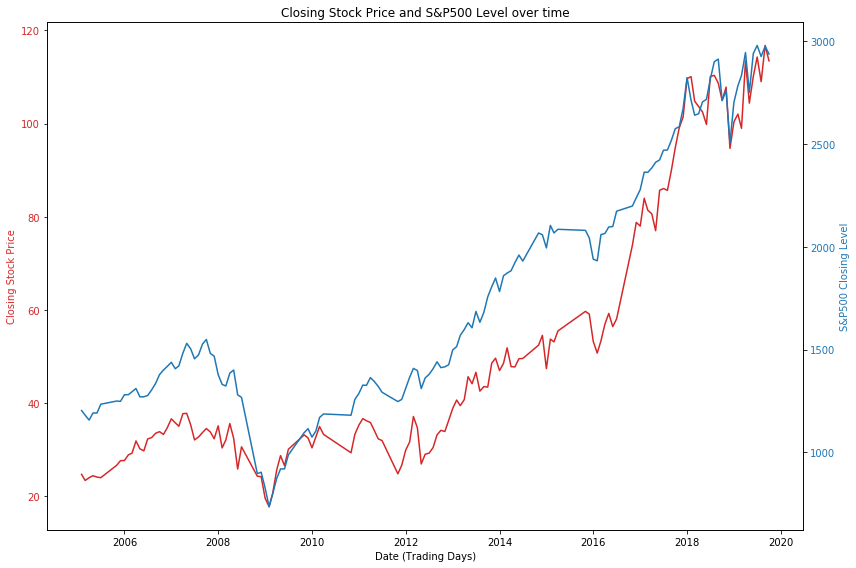

In [2]:
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# the code below plots the stock price and market level data

time = my_data.index

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date (Trading Days)')
ax1.set_ylabel('Closing Stock Price', color = color)
ax1.plot(time, my_data.close, color = color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('S&P500 Closing Level', 
               color = color)  # we already handled the x-label with ax1
ax2.plot(time, my_data.close_market, color = color)
ax2.tick_params(axis = 'y', labelcolor = color)

plt.title('Closing Stock Price and S&P500 Level over time')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## **II. Establishing the Order of Integration**

Before modeling, the order of integration of our time series needs to be established. If they are not stationary, aka I(0), then we will have issues with auto-correlation in our residuals, which violates an essential assumption made by many statistical models (meaning our model would be bad). To determine the order of integration, Auto-Correlation Functions (ACFs) and Augmented-Dickey Fuller (ADF) Tests can help us out.

The ACFs show strong evidence of autocorrelation at 50 lags. This is backed up by the ADF tests.

Note: stationary is a short way of saying that the mean and variance of the series do not vary over time.

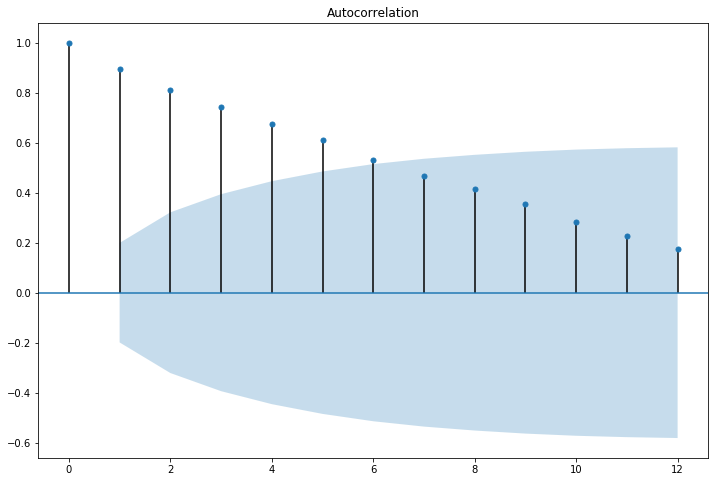

In [3]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the ACF for train period with 50 lags
plot = plot_acf(my_data_train.close, lags = 12)

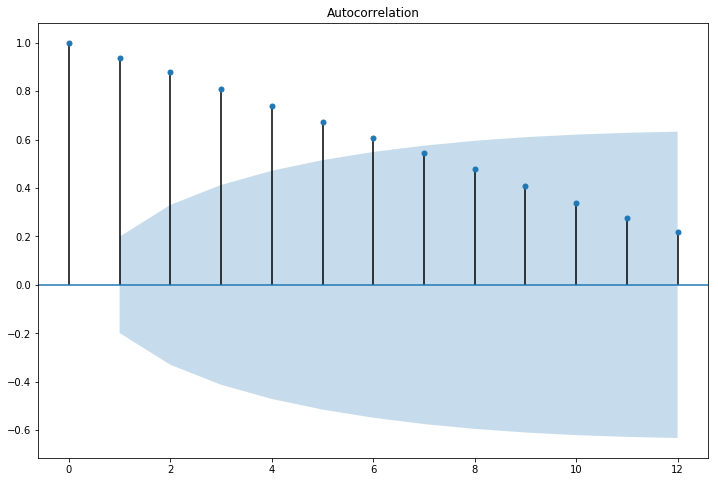

In [4]:
# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the ACF for train period with 50 lags
plot = plot_acf(my_data_train.close_market, lags = 12)

In [5]:
# to suppress warnings
warnings.filterwarnings('ignore')

# imports the Augmented Dickey-Fuller Test for establishing the order of integration of 
# time series
from statsmodels.tsa.stattools import adfuller

# performs ADF tests with no constant, a constant, and a constant plus linear trend on
# closing share prices
for i in ['nc', 'c', 'ct']:
    result = adfuller(my_data_train.close, regression = i)
    print('ADF Statistic with %s for Closing my_stock_train price: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

# performs ADF tests with no constant, a constant, and a constant plus linear trend on
# closing share prices
for i in ['nc', 'c', 'ct']:
    result = adfuller(my_data_train.close_market, regression = i)
    print('ADF Statistic with %s for Closing my_market_train level: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

ADF Statistic with nc for Closing my_stock_train price: 0.780197
p-value: 0.881542

ADF Statistic with c for Closing my_stock_train price: -1.129509
p-value: 0.703162

ADF Statistic with ct for Closing my_stock_train price: -2.054251
p-value: 0.571600

ADF Statistic with nc for Closing my_market_train level: 1.521905
p-value: 0.968415

ADF Statistic with c for Closing my_market_train level: 0.396423
p-value: 0.981361

ADF Statistic with ct for Closing my_market_train level: -0.495238
p-value: 0.983619



The first difference of the closing stock prices and market levels in the training period appear to be stationary based on the results of the ACF tests and ADFs, so we can proceed with modeling the first differences of these data.

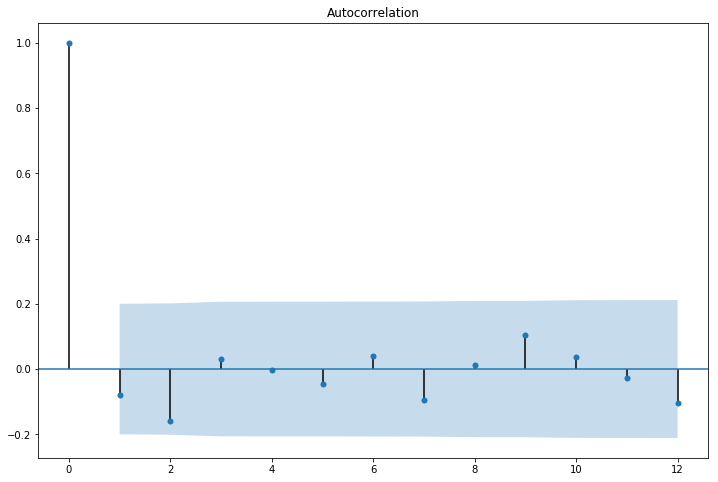

In [6]:
# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the ACF for train period with 50 lags
plot = plot_acf(my_data_train.close.diff().dropna(), lags = 12)

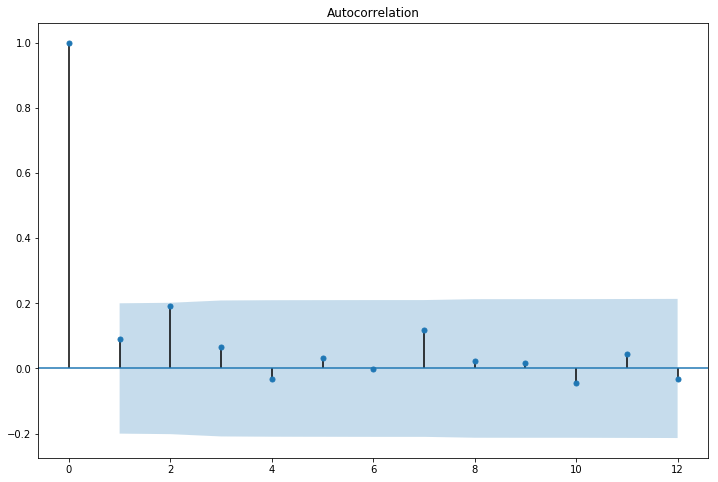

In [7]:
# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the ACF for train period with 50 lags
plot = plot_acf(my_data_train.close_market.diff().dropna(), lags = 12)

In [8]:
# performs ADF tests with no constant, a constant, and a constant plus linear trend on differenced
# closing share prices
for i in ['nc', 'c', 'ct']:
    result = adfuller(my_data_train.close.diff().dropna(), regression = i)
    print('ADF Statistic with %s for Closing my_stock_train price: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

# performs ADF tests with no constant, a constant, and a constant plus linear trend on differenced
# closing market level
for i in ['nc', 'c', 'ct']:
    result = adfuller(my_data_train.close_market.diff().dropna(), regression = i)
    print('ADF Statistic with %s for Closing my_market_train level: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

ADF Statistic with nc for Closing my_stock_train price: -8.127981
p-value: 0.000000

ADF Statistic with c for Closing my_stock_train price: -8.265117
p-value: 0.000000

ADF Statistic with ct for Closing my_stock_train price: -8.263435
p-value: 0.000000

ADF Statistic with nc for Closing my_market_train level: -5.077627
p-value: 0.000001

ADF Statistic with c for Closing my_market_train level: -5.225443
p-value: 0.000008

ADF Statistic with ct for Closing my_market_train level: -5.344873
p-value: 0.000046



## **Testing for Cointegration Using Engel-Granger Approach**

The Engel-Granger process is estimating the regression of the I(1) target variable on the I(1) independent variable. If the residuals are stationary, there is cointegration. The ADF tests indicate that JP Morgan's stock and the S&P500 are cointegrated in our sample period.

In [9]:
# imports statsmodels as sm
import statsmodels.api as sm

# adds a constant term
my_data_train = sm.add_constant(my_data_train)
# estimates a linear regression of the closing share price on the lagged closing market level
lr_model = sm.OLS(my_data_train.close, my_data_train[['const', 'close_market']])
lr_model_fit = lr_model.fit(cov_type='HC0')

# prints a summary
print(lr_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     447.7
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           1.00e-37
Time:                        02:01:51   Log-Likelihood:                -253.10
No. Observations:                  97   AIC:                             510.2
Df Residuals:                      95   BIC:                             515.4
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.3464      1.807     -0.745   

In [10]:
# does the ADF test on the residuals

for i in ['nc', 'c', 'ct']:
    result = adfuller(lr_model_fit.resid, regression = i)
    print('ADF Statistic with %s for Closing my_stock_train price: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

ADF Statistic with nc for Closing my_stock_train price: -3.396135
p-value: 0.000700

ADF Statistic with c for Closing my_stock_train price: -3.379076
p-value: 0.011693

ADF Statistic with ct for Closing my_stock_train price: -3.548883
p-value: 0.034444



## **Estimating the ECM**

The error-correction term in the ECM must be negative. The lagged residuals from the linear regression represent the deviation from the long-run relationship in the previous period. The intuition is if our stock price is above its long-run equilibrium with the market, the negative coefficient pulls it back down. If it is below the long-run equilibrium, the negatives will cancel out and become positive pulling the stock price back up. That is the magic of the ECM.

Our model trained on the sample period meets this requirement.

In [11]:
# attaches the residuals to the training data set and shifts them down be one to get them alligned properly to be the
# lagged residuals of the linear model in the ECM
my_data_train['disequilibrium'] = lr_model_fit.resid
my_data_train.disequilibrium = my_data_train.disequilibrium.shift(1)

# creates a copy of the training data
diff_train = my_data_train.copy()
# for i in the list of columns I want to difference...
for i in ['close', 'close_l1', 'close_l2', 'close_l3', 'close_market_l1', 'close_market_l2', 'close_market_l3']:
    # difference column i
    diff_train[i] = diff_train[i].diff()
# drop the first row because you lose a row when differencing; you can't difference a row without a prior observation
diff_train = diff_train.dropna()

# creates a list of predictors for easy referencing
predictors = ['close_l1', 'close_l2', 'close_l3', 
              'close_market_l1', 'close_market_l2', 'close_market_l3', 
             'disequilibrium', 'const']


# estimates a linear regression of the closing share price on the lagged closing market level
ecm_train = sm.OLS(diff_train.close, diff_train[predictors])
ecm_train_fit = ecm_train.fit(cov_type='HC0')

# prints a summary
print(ecm_train_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     5.144
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           6.18e-05
Time:                        02:01:52   Log-Likelihood:                -221.55
No. Observations:                  96   AIC:                             459.1
Df Residuals:                      88   BIC:                             479.6
Df Model:                           7                                         
Covariance Type:                  HC0                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
close_l1            0.0260      0.118     

I also estimated an autoregressive model with 3 lags as a contrast to the ECM. Based on the in-sample results, the ECM seems to have more explanatory power than the AR model. Their relative performance must also be assessed on the out of sample data.

In [12]:
# looks at the performance of the 3 lag autoregressive model

# creates a list of autoregressive predictors
ar_predictors = ['close_l1', 'close_l2', 'close_l3', 'const']

# estimates a linear regression of the closing share price on the lagged closing market level
ar_train = sm.OLS(diff_train.close, diff_train[ar_predictors])
ar_train_fit = ar_train.fit()

# prints a summary
print(ar_train_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.957
Date:                Tue, 08 Oct 2019   Prob (F-statistic):              0.126
Time:                        02:01:52   Log-Likelihood:                -228.38
No. Observations:                  96   AIC:                             464.8
Df Residuals:                      92   BIC:                             475.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
close_l1       0.0699      0.103      0.680      0.4

## **Out of Sample Testing**

After building functions to do rolling forecasts on the testing period, the results are in. The AR and ECM perform about the same in terms of Mean Absolute Error. Looking at the coefficient on the last sequential model shows the error-correction term no longer has a significant t-statistic. Perhaps the cointegrated relationship changed or disappeared at some point in my data set making the ECM a poor modeling choice. I investigate by plotting the error-correction parameter.

In [13]:
# redoes the data transformations to ensure everything is the way I want it

diff_data = my_data.copy()
diff_data = diff_data.diff().dropna() 
diff_data = sm.add_constant(diff_data)
diff_test = diff_data[-50:]
diff_train = diff_data[~diff_data.isin(diff_test).all(1)]

my_data = sm.add_constant(my_data)
my_data_test = my_data[-50:]
my_data_train = my_data[~my_data.isin(my_data_test).all(1)]

predictors = ['close_l1', 'close_l2', 'close_l3', 
              'close_market_l1', 'close_market_l2', 'close_market_l3', 
             'disequilibrium', 'const']

In [14]:
# defines a function to perform rolling forecasts with a ECM and intakes a y_var as a string
# X_vars as a list, lr_X_vars as a list, and the rest of the inputs are dataframes, with lr_
# indicating level variables used to estimate the long-run relationship, and diff_ representing
# differenced data
def roll_forecast_ecm(y_var, X_vars, lr_X_vars, lr_train, lr_test, diff_train, diff_test):
    
    # creates two new dataframes that will be added to as the forecast rolls 
    history = lr_train
    diff_history = diff_train
    
    # estimates a linear model to predict the longrun relationship
    lr_model_train = sm.OLS(history[[y_var]], history[lr_X_vars])
    # fits the lr model
    lr_model_train_fit = lr_model_train.fit(cov_type='HC0')
    # adds a disequilibrium column for the training period
    diff_train['disequilibrium'] = lr_model_train_fit.resid.shift(1)
    
    
    # this chunk of data does one-step ahead predictions of the disequilibrium    
    
    # creates an empty list that will hold the residuals for the next period
    disequilibrium = []
    
    # loops through the indexes of the set being forecasted
    for i in range(len(lr_test)):
        
        # estimates a linear model to predict the longrun relationship
        lr_model = sm.OLS(history[[y_var]], history[lr_X_vars])
        # fits the lr model
        lr_model_fit = lr_model.fit(cov_type='HC0')
        # forecasts the disequilibrium in the next period and appends it to the list by predicting 
        # the closing price using the 1st lagged value of the independent variable at t+1, which makes it
        # at time t, and subtracting the closing price at time t, giving the residual for time t, which is 
        # t - 1 for the future value we want to predict
        disequilibrium_hat = (float(lr_model_fit.predict(history[-1:][lr_X_vars]))
                             - float(history[-1:].close.values))
        disequilibrium.append(disequilibrium_hat)
        # grabs the observation at the ith index
        obs = lr_test[i : i + 1]
        # appends the observation to the estimation data set
        history = history.append(obs)
        
    # creates a column of the lagged disequilibrium values
    diff_test['disequilibrium'] = disequilibrium
    
    
    # this chunk of code does the 1-step ahead ECM estimation and prediction
    
    predictions = []
    
    # this list will store the error_correction coefficients  
    error_correction_coefficients = []
    # this list stores the standard error of the EC coefficients
    error_correction_coef_stderr = []
    
    # loops through the indexes of the set being forecasted
    for i in range(len(diff_test)):
        
        # estimates an ECM to predict future values
        ecm_model = sm.OLS(diff_history[[y_var]], diff_history[X_vars])
        # fits the ECM
        ecm_model_fit = ecm_model.fit(cov_type='HC0')
        # predicts the future closing price change and appends it to the list of predictions
        delta_y_hat = float(ecm_model_fit.predict(diff_test[i : i + 1][X_vars]))
        predictions.append(delta_y_hat)
        # grabs the observation at the ith index
        obs = diff_test[i : i + 1]
        # appends the observation to the estimation data set
        diff_history = diff_history.append(obs)
        
        # appends the error_correction coefficient to the list  
        error_correction_coefficients.append(ecm_model_fit.params.disequilibrium)
        error_correction_coef_stderr.append(ecm_model_fit.HC0_se.disequilibrium)
    
    # adds columns for our lists
    diff_test['delta_y_hat'] = predictions     
    diff_test['ec_coef'] = error_correction_coefficients
    diff_test['ec_stderr'] = error_correction_coef_stderr
    
    # returns predictions
    return(diff_test, ecm_model_fit)  

In [15]:
# defines a function to perform rolling forecasts with a auto-regressive model and intakes a y_var as a string
# X_vars as a list, lr_X_vars as a list, and the rest of the inputs are dataframes of differenced values
def roll_forecast_ar(y_var, X_vars, diff_train, diff_test):
    
    # creates two new dataframes that will be added to as the forecast rolls 
    diff_history = diff_train
    
    
    # this chunk of code does the 1-step ahead AR estimation and prediction
    
    predictions = []
  
    
    # loops through the indexes of the set being forecasted
    for i in range(len(diff_test)):
        
        # estimates an AR to predict future values
        ar_model = sm.OLS(diff_history[[y_var]], diff_history[X_vars])
        # fits the AR
        ar_model_fit = ar_model.fit(cov_type='HC0')
        # predicts the future closing price change and appends it to the list of predictions
        delta_y_hat = float(ar_model_fit.predict(diff_test[i : i + 1][X_vars]))
        predictions.append(delta_y_hat)
        # grabs the observation at the ith index
        obs = diff_test[i : i + 1]
        # appends the observation to the estimation data set
        diff_history = diff_history.append(obs)
    
    diff_test['delta_y_hat'] = predictions     
    
    # returns predictions
    return(diff_test, ar_model_fit)  

In [16]:
(y_var, X_vars, lr_X_vars, lr_train, lr_test, diff_train, diff_test) = ('close', 
                                                                        predictors, 
                                                                        ['close_market', 'const'], 
                                                                        my_data_train.dropna(), 
                                                                        my_data_test , 
                                                                        diff_train, 
                                                                        diff_test)      

ecm_results = roll_forecast_ecm(y_var, X_vars, lr_X_vars, lr_train, lr_test, diff_train, diff_test)

print('Mean Absolute Error over Test Data Set: ' + 
      str(sum(abs(ecm_results[0].close - ecm_results[0].delta_y_hat)) / len(ecm_results[0])))
print('')
print(ecm_results[1].summary())

Mean Absolute Error over Test Data Set: 4.587971837232232

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     1.892
Date:                Tue, 08 Oct 2019   Prob (F-statistic):             0.0754
Time:                        02:01:53   Log-Likelihood:                -395.57
No. Observations:                 145   AIC:                             807.1
Df Residuals:                     137   BIC:                             831.0
Df Model:                           7                                         
Covariance Type:                  HC0                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

In [17]:
ar_results = roll_forecast_ar(y_var, ['close_l1', 'close_l2', 'close_l3'], 
                              diff_train, diff_test)

print('Mean Absolute Error over Test Data Set: ' + 
      str(sum(abs(ar_results[0].close - ar_results[0].delta_y_hat)) / len(ar_results[0])))
print('')
print(ar_results[1].summary())

Mean Absolute Error over Test Data Set: 4.233433496969095

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     3.132
Date:                Tue, 08 Oct 2019   Prob (F-statistic):             0.0276
Time:                        02:01:54   Log-Likelihood:                -399.28
No. Observations:                 145   AIC:                             804.6
Df Residuals:                     142   BIC:                             813.5
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

Looking at the parameter plotted with its standard error bars shows that the error correction coefficient is not stable over time and its 95% confidence interval bars breach the 0 line, indicating the coefficient is no longer significant. Our ECM is not a good model of JP Morgan's stock going forward.

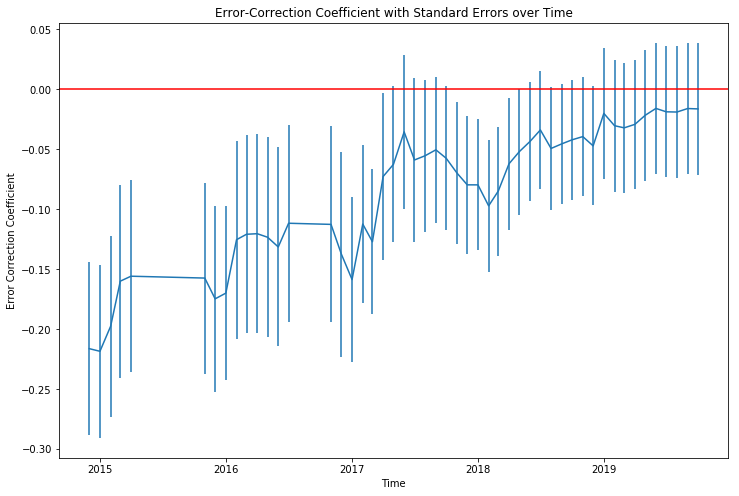

In [18]:
plt.errorbar(ecm_results[0].index, ecm_results[0].ec_coef, yerr = ecm_results[0].ec_stderr)
plt.axhline(color = 'r')
plt.title('Error-Correction Coefficient with Standard Errors over Time')
plt.xlabel('Time')
plt.ylabel('Error Correction Coefficient')
plt.show()